# Prescriptor Experiments
#### This notebook is to replicate the process used in [Discovering Effective Policies for Land-Use Planning](https://doi.org/10.48550/arXiv.2311.12304)

In [56]:
import os
from pathlib import Path

import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data import constants
from data.eluc_data import ELUCData
from prescriptors.nsga2.candidate import Candidate
from prescriptors.nsga2.land_use_prescriptor import LandUsePrescriptor
from prescriptors.prescriptor_manager import PrescriptorManager
from prescriptors.heuristics.heuristics import EvenHeuristic, PerfectHeuristic
from predictors.neural_network.neural_net_predictor import NeuralNetPredictor

In [57]:
dataset = ELUCData()

### Load Results

In [58]:
TOTAL_GENS = 100

results_dir = Path("prescriptors/nsga2/training_runs/fixed-distance")

In [59]:
def create_pareto_df(gen: int, results_dir: Path):
    last_gen_filename = results_dir / f"{gen}.csv"
    last_gen_df = pd.read_csv(last_gen_filename)
    pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    pareto_df = pareto_df.sort_values(by='change', ascending=True)
    return pareto_df

In [60]:
pareto_df = create_pareto_df(100, results_dir)

### Figure Save Dir

In [61]:
figure_dir = Path("experiments/figures/test")
figure_dir.mkdir(parents=True, exist_ok=True)

## Generation Plotting

In [62]:
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = os.path.join(dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen:int, results_dir: Path):
    pareto_list = []
    # First, go through each gen and add prescriptors that aren't already dominated.
    for gen in range(1, final_gen + 1):
        gen_path = results_dir / f"{gen}.csv"      
        gen_df = pd.read_csv(gen_path)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        for idx, row in gen_pareto_df.iterrows():
            pareto = True
            for p in pareto_list:
                # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
                #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
                #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
                if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                    pareto = False
                    break
            if pareto:
                pareto_list.append(row)

    # Go through the results and remove prescriptors that got dominated by later ones.
    filtered_pareto_list = []
    for i in range(len(pareto_list)):
        row = pareto_list[i]
        pareto = True
        for j in range(i+1, len(pareto_list)):
            p = pareto_list[j]
            # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
            #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
            #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
            if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                pareto = False
                break
        if pareto:
            filtered_pareto_list.append(row)

    return pd.DataFrame(filtered_pareto_list)


def plot_gens(dir, gens, save_path=None):
    """
    Plots the pareto front for multiple generations.
    :param dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = get_merged_df(dir, gens)
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        merged_df[merged_df["Name"] == curve_name].plot(x='change',
                       y='ELUC',
                       marker='o',
                       ylabel='ELUC',
                       ax=ax,
                       color=colors[i],
                       label="Gen " + str(gen))

    overall_pareto_df = get_overall_pareto_df(gens[-1], dir)
    overall_pareto_df = overall_pareto_df.sort_values(by="change")
    overall_pareto_df.plot(x='change', y='ELUC', c='r', marker='o', ax=ax, label="Final Pareto Front")
    #plt.xlim(0, 0.4)
    plt.grid() 
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 4, 3]
    # plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    plt.legend(prop={'size': 9})
    #plt.title("Pareto Fronts Across Generations")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

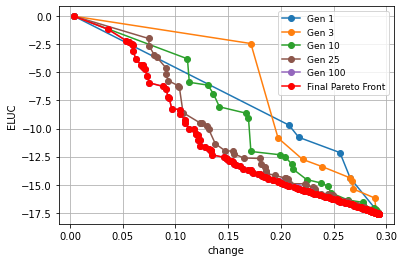

In [63]:
gens_to_plot = [1, 3, 10, 25, 100]
plot_gens(results_dir, gens_to_plot, save_path=None)

In [64]:
def get_gen_df(gen: int, results_dir: Path):
    gen_filename = results_dir / f"{gen}.csv"
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens: list, results_dir: Path):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen, results_dir))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [65]:
def plot_all_gens(gens: list, results_dir: Path, save_path=None):
    all_gens_df = get_all_gens_df(gens, results_dir)
    fig, ax = plt.subplots()

    all_gens_df.plot.scatter(x='change',
                             y='ELUC',
                             ax=ax,
                             label="All prescriptors evaluated")
    # Plot last gen's pareto front in red
    
    #get_pareto_df(dir, gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Gen 100 Pareto Front")
    overall_pareto = get_overall_pareto_df(gens[-1], results_dir)
    overall_pareto.plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Final Pareto Front")
    plt.grid()
    #plt.title("All Generations All Prescriptor Performance")
    plt.legend(loc="upper left")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300) 
    plt.show()

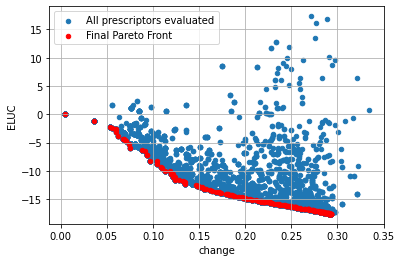

In [66]:
all_gens = [a + 1 for a in range(100)]
plot_all_gens(all_gens, results_dir, save_path=None)

In [67]:
all_pareto_df = get_overall_pareto_df(100, results_dir)

## Comparison with Heuristic

In [68]:
def load_candidate(results_dir: Path, cand_id: str, cand_params: dict[str, int]) -> Candidate:
    cand_path = results_dir / str(int(cand_id.split('_')[0])+1) / f"{cand_id}.pt"
    cand = Candidate(**cand_params, device="mps", cand_id=cand_id)
    cand.load_state_dict(torch.load(cand_path))
    return cand

In [69]:
nnp = NeuralNetPredictor.from_pretrained("predictors/neural_network/trained_models/no_overlap_nn")

candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]), "hidden_size": 16, "out_size": len(constants.RECO_COLS)}
# Set up new PrescriptorManager
cands = [load_candidate(results_dir, cand_id, candidate_params) for cand_id in all_pareto_df["id"]]
prescs = {cand.cand_id: LandUsePrescriptor(cand, dataset.encoder) for cand in cands}
torch_manager = PrescriptorManager(prescs, nnp)

In [70]:
test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = dataset.encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

### Trained Prescriptors

In [71]:
def evaluate_prescriptor(prescriptor_manager: PrescriptorManager, cand_id: str, context_df: pd.DataFrame):
    context_actions_df = prescriptor_manager.prescribe(cand_id, context_df)
    eluc_df, change_df = prescriptor_manager.predict_metrics(context_actions_df)
    return eluc_df["ELUC"].mean(), change_df["change"].mean()

In [72]:
assert len(all_pareto_df["id"].unique()) == len(all_pareto_df)

ids = all_pareto_df["id"].tolist()
elucs = []
changes = []
for cand_id in tqdm(ids):
    eluc, change = evaluate_prescriptor(torch_manager, cand_id, context_df)
    elucs.append(eluc)
    changes.append(change)

100%|██████████| 179/179 [00:51<00:00,  3.45it/s]


### Heuristics

In [73]:
pcts = [i/len(ids) for i in range(1, len(ids) + 1)]

linreg = LinearRegression()
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
coefs = linreg.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])

even_manager = PrescriptorManager({str(pct): EvenHeuristic(pct, "secdf") for pct in pcts}, nnp)
perfect_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, nnp)

In [74]:
even_elucs = []
even_changes = []
perfect_elucs = []
perfect_changes = []
for pct in tqdm(pcts):
    even_eluc, even_change = evaluate_prescriptor(even_manager, str(pct), context_df)
    even_elucs.append(even_eluc)
    even_changes.append(even_change)
    perfect_eluc, perfect_change = evaluate_prescriptor(perfect_manager, str(pct), context_df)
    perfect_elucs.append(perfect_eluc)
    perfect_changes.append(perfect_change)

100%|██████████| 179/179 [01:15<00:00,  2.39it/s]


### Comparison

In [75]:
def order_pareto_points(changes, elucs):
    zipped = zip(changes, elucs)
    ordered = sorted(zipped, key=lambda x: x[0])
    return zip(*ordered)

In [76]:
changes_sorted, elucs_sorted = order_pareto_points(changes, elucs)

In [77]:
def plot_result_pareto(all_results, save_path=None):
    for result_name, results in all_results.items():
        plt.scatter(results[0], results[1], color=results[2], label=result_name)

    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

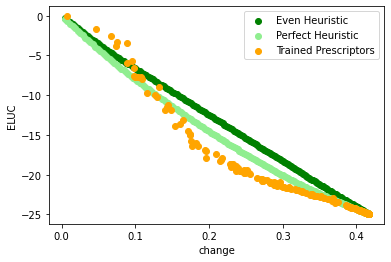

In [78]:
all_results = {
    "Even Heuristic": (even_changes, even_elucs, "green"),
    "Perfect Heuristic": (perfect_changes, perfect_elucs, "lightgreen"),
    "Trained Prescriptors": (changes, elucs, "orange")
}
plot_result_pareto(all_results)

In [79]:
def filter_dominating(changes, elucs):
    """
    Gets indices of points that are not dominated by any other point.
    """
    non_dominated_idxs = []
    for i in range(len(changes)):
        dominated = False
        for j in range(len(changes)):
            if i != j and changes[i] >= changes[j] and elucs[i] >= elucs[j]:
                dominated = True
                break
        if not dominated:
            non_dominated_idxs.append(i)
    
    return [changes[i] for i in non_dominated_idxs], [elucs[i] for i in non_dominated_idxs]


def two_dim_decreasing_neg_hypervolume(x, y, right=1):
    """
    Computes the hypervolume of a 2d pareto.
    We use the sklearn AUC function to find the area between our curve and y = 0,
    then we add the area of the rectangle to the right of the pareto.
    This assumes the y coordinate of the reference point is 0 (which it is in our ELUC case).
    We only consider points under y = 0, adding point 0,0 to the pareto if it is not there.
    :param x: List of x coordinates between [0, 1]
    :param y: List of y coordinates
    :param right: the rightmost edge to compute the rectangle to. Defaults to 1.
    """

    assert len(x) == len(y)
    assert all([0 <= x_i <= 1 for x_i in x])
    assert right >= max(x)

    # Filter out positive y values
    neg_idxs = [i for i in range(len(y)) if y[i] < 0]
    x = [x[i] for i in neg_idxs]
    y = [y[i] for i in neg_idxs]

    # Sort the pareto by x
    sorted_x = sorted(x)
    sorted_y = [y[x.index(sorted_x[i])] for i in range(len(x))]

    # Add point 0,0 if it is not there
    if sorted_x[0] != 0:
        sorted_x = [0] + sorted_x
        sorted_y = [0] + sorted_y

    # Add bottom right point if it is not there
    if sorted_x[-1] != right:
        sorted_x.append(right)
        sorted_y.append(sorted_y[-1])

    # Take the rectangle that is to the top right of each point.
    area = 0
    for i in range(len(sorted_x) - 2, -1, -1):
        area += (sorted_x[i] - sorted_x[i + 1]) * sorted_y[i]

    return area

In [80]:
# Filter out points that are dominated by others
changes_filtered, elucs_filtered = filter_dominating(changes_sorted, elucs_sorted)

print(f"Even hypervolume: {two_dim_decreasing_neg_hypervolume(even_changes, even_elucs)}")
print(f"Perfect hypervolume: {two_dim_decreasing_neg_hypervolume(perfect_changes, perfect_elucs)}")
print(f"Trained hypervolume: {two_dim_decreasing_neg_hypervolume(changes_filtered, elucs_filtered)}")

Even hypervolume: 19.87827885124927
Perfect hypervolume: 20.445184246654176
Trained hypervolume: 20.612026679495887


## Examine Results

In [81]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

def plot_selected_points(selected_points, save_path=None):
    for point_name, point in selected_points.items():
        plt.scatter([point[0]], [point[1]], color=point[2], label=point_name)

    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    plt.xlim([0, 0.4])
    plt.ylim([-25, 0])
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

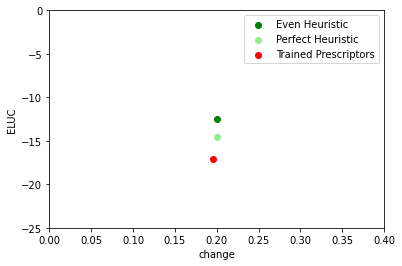

In [82]:
pct = 0.2
even_idx = get_idx_close(pct, even_changes)
perfect_idx = get_idx_close(pct, perfect_changes)
idx = get_idx_close(pct, changes_sorted) - 1

selected_points = {
    "Even Heuristic": (even_changes[even_idx], even_elucs[even_idx], "green"),
    "Perfect Heuristic": (perfect_changes[perfect_idx], perfect_elucs[perfect_idx], "lightgreen"),
    "Trained Prescriptors": (changes_sorted[idx], elucs_sorted[idx], "red"),
}

plot_selected_points(selected_points)

In [83]:
def trained_prescribe_and_predict(prescriptor_manager: PrescriptorManager, cand_id: str, context_df: pd.DataFrame):
    context_actions_df = prescriptor_manager.prescribe(cand_id, context_df)
    eluc_df, change_df = prescriptor_manager.predict_metrics(context_actions_df)
    context_actions_df["ELUC"] = eluc_df["ELUC"]
    context_actions_df["change"] = change_df["change"]
    return context_actions_df

In [84]:
unsorted_idx = changes.index(changes_sorted[idx])
trained_id = all_pareto_df["id"].iloc[unsorted_idx]
trained_result = trained_prescribe_and_predict(torch_manager, trained_id, context_df)

even_result = trained_prescribe_and_predict(even_manager, str(pcts[even_idx]), context_df)
perfect_result = trained_prescribe_and_predict(perfect_manager, str(pcts[perfect_idx]), context_df)

In [85]:
def plot_expanded(result_dict: dict, save_path=None):
    # Evolved first so that it is on the bottom
    for sample_name, result in result_dict.items():
        plt.scatter(result[0], result[1], color=result[2], label=sample_name)
    
    # Rearrange legend (from stackoverflow)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [1, 2, 0]
    # plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    #plt.title("Expanded view of ~20% change prescriptors (subsampled)")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

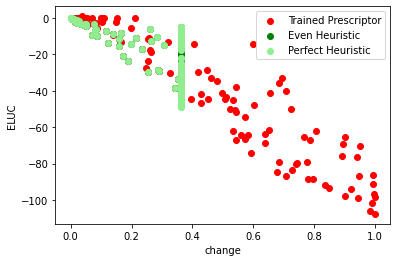

In [86]:
sample =  trained_result.sample(frac=0.01, random_state=42)
even_sample = even_result.loc[sample.index]
perfect_sample = perfect_result.loc[sample.index]

expanded_results = {
    "Trained Prescriptor": (sample["change"], sample["ELUC"], "red"),
    "Even Heuristic": (even_sample["change"], even_sample["ELUC"], "green"),
    "Perfect Heuristic": (perfect_sample["change"], perfect_sample["ELUC"], "lightgreen"),
}

plot_expanded(expanded_results)

In [87]:
def create_diff_df(trained_result, perfect_result):
    eluc_diff = trained_result["ELUC"] - perfect_result["ELUC"]
    change_diff = trained_result["change"] - perfect_result["change"]
    diff_df = pd.concat([eluc_diff, change_diff], axis=1)

    return diff_df

In [88]:
trained_diff = create_diff_df(sample, perfect_sample)

In [89]:
def plot_diffs(diff_df, save_path=None):
    
    dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
    other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]

    plt.scatter(diff_df["change"], diff_df["ELUC"], label="No domination")
    plt.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates")
    plt.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates")
    plt.axhline(0, color="black", linestyle="--")
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Change Difference")
    plt.ylabel("ELUC Difference")
    #plt.title("Change Diff vs. ELUC Diff Between Trained and Perfect (subsampled)")
    plt.legend()
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

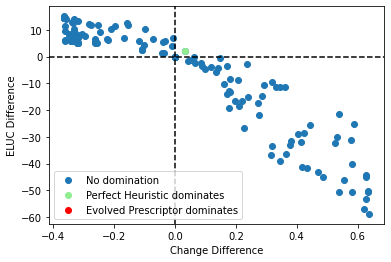

In [90]:
plot_diffs(trained_diff)

In [91]:
def display_dominating(diff_df):
    low_change_idx = diff_df["change"][(diff_df["change"] < 0)].index
    low_change_eluc_diff = diff_df["ELUC"][low_change_idx]
    low_change_neg_eluc_diff = low_change_eluc_diff[low_change_eluc_diff < 0]
    print(f"Number less change better ELUC: {len(low_change_neg_eluc_diff)}")
    if len(low_change_neg_eluc_diff) > 0:
        min_idx = low_change_neg_eluc_diff.sort_values().index[0]
        print(f"Max difference in ELUC with less change: {diff_df['ELUC'][min_idx]}")

    signif = low_change_neg_eluc_diff[abs(low_change_neg_eluc_diff) > 0.05]
    print(f"Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: {len(signif)}")
    print(f"Average difference in change for these points: {diff_df['change'].loc[signif.index].mean()}")
    print(f"Average difference in ELUC for these points: {signif.mean()}")
    print()

In [92]:
display_dominating(trained_diff)

Number less change better ELUC: 0
Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 0
Average difference in change for these points: nan
Average difference in ELUC for these points: nan



In [93]:
def plot_avg_presc(result_dict, save_path=None):
    xticks = np.arange(len(constants.DIFF_RECO_COLS))
    i = 0
    width = 1 / (len(result_dict) + 1)
    for result_name, result in result_dict.items():
        plt.bar(xticks + i * width, result[0][constants.DIFF_RECO_COLS].mean(), width=width, label=result_name, color=result[1])
        i += 1
    
    plt.xticks(xticks + (len(result_dict)-1)/2 * width, constants.DIFF_RECO_COLS, rotation=90)
    plt.legend()
    plt.grid()
    #plt.title("Average land use change for each prescriptor")
    fig = plt.gcf()
    fig.set_tight_layout(True)
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

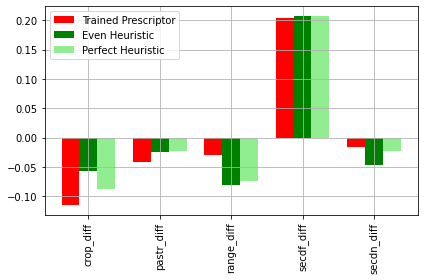

In [94]:
plot_avg_presc({
    "Trained Prescriptor": (sample, "red"),
    "Even Heuristic": (even_sample, "green"),
    "Perfect Heuristic": (perfect_sample, "lightgreen"),
})

#### See what features cause more change

In [95]:
def plot_corrs(result_df, save_path=None):
    rs = []
    for col in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
        feat = result_df[col]
        if col == "lat" or col == "lon":
            feat = abs(feat)
        rs.append(feat.corr(result_df["change"]))
    print(rs)

    labels = constants.LAND_USE_COLS + constants.NONLAND_FEATURES
    labels[labels.index("lat")] = "abs(lat)"
    labels[labels.index("lon")] = "abs(lon)"
    plt.bar(labels, rs)
    plt.xticks(rotation=90)
    plt.xlabel("Context Feature")
    plt.ylabel("r value")
    plt.title("Linear Correlation Between Context and Amount of Prescribed Change")
    plt.grid(axis="y")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

[0.833829812009902, 0.6505255840955172, -0.25363241947260634, -0.2565692273582894, -0.04820242793010668, -0.07578107423921765, 0.0306483354548232, 0.14394597756353772, 0.31080526300406486, -0.2708375110699364, -0.1873337078723743, 0.009221983705203095]


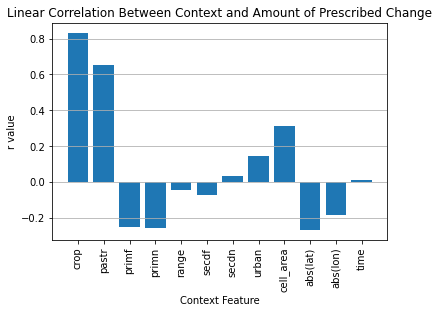

In [96]:
plot_corrs(trained_result)

In [97]:
def plot_context_change(trained_sample, feature, save):
    plt.scatter(trained_sample[feature], trained_sample["change"])
    plt.title(f"Context {feature} vs. Amount of Prescribed Change")
    plt.ylabel("Change")
    plt.xlabel(feature)
    if feature in constants.LAND_USE_COLS:
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="y=x")
        plt.plot([0, 1], [1, 0], color="red", linestyle="--", label="y=1-x")
        plt.legend()
    if save:
        plt.savefig(f"figures/{feature}change.png", format="png", dpi=300)
    plt.show()

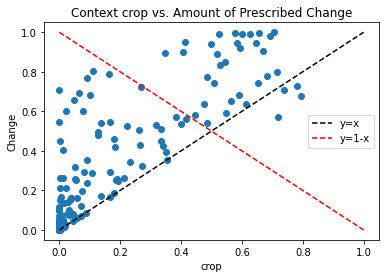

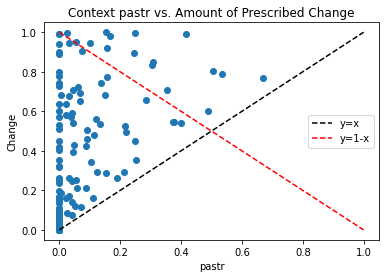

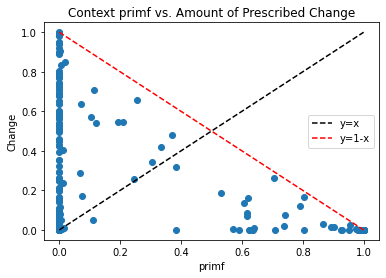

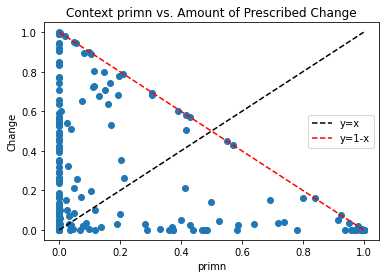

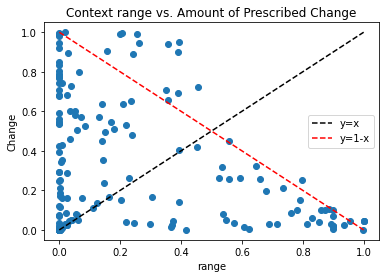

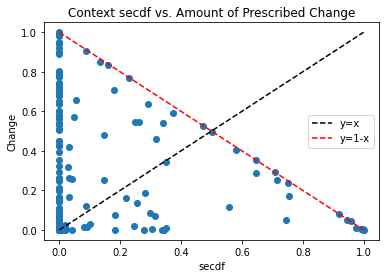

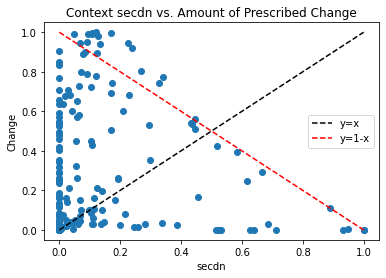

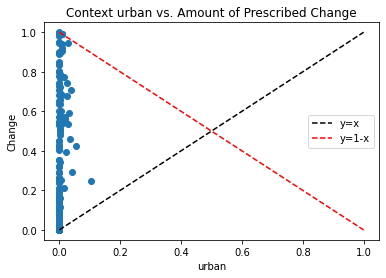

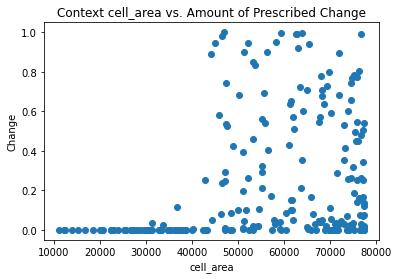

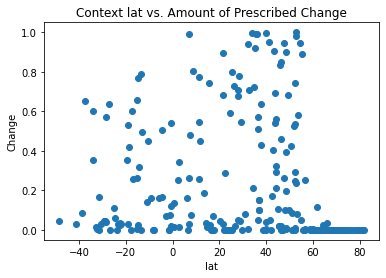

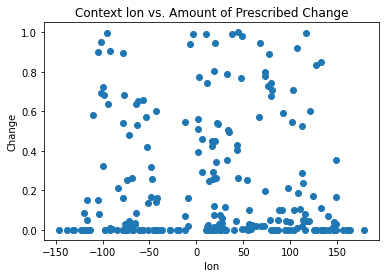

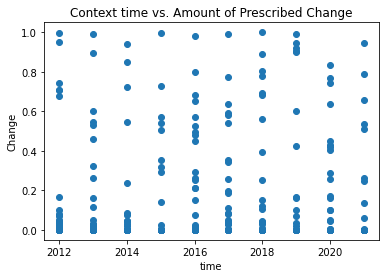

In [98]:
for feature in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    plot_context_change(sample, feature, False)

## Compare to Global Warming

In [99]:
pcts = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
total_emissions = []
total_changes = []
warming_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, nnp)
for pct in tqdm(pcts):
    result_df = warming_manager.prescribe(str(pct), dataset.test_df.loc[2021][constants.CAO_MAPPING["context"]])
    eluc_df, change_df = perfect_manager.predict_metrics(result_df)
    result_df["ELUC"] = eluc_df["ELUC"]
    result_df["change"] = change_df["change"]
    result_df["total_emissions"] = result_df["ELUC"] * result_df["cell_area"]
    result_df["total_change"] = result_df["change"] * result_df["cell_area"]
    total_emissions.append(result_df["total_emissions"].sum())
    total_changes.append(result_df["total_change"].sum() / result_df["cell_area"].sum())

100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


In [100]:
# Weight of CO2 vs. C
conversion = 3.664
# Remaining Carbon budget
rcb = 250
rcb2 = 1200
# Yearly net emissions
yearly = 20

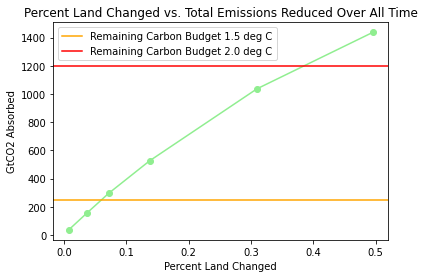

In [101]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [-1 * t * conversion / 1e9 for t in total_emissions], marker="o", color="lightgreen")
plt.axhline(y=rcb, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.axhline(y=rcb2, color='red', label="Remaining Carbon Budget 2.0 deg C")
plt.legend()
plt.title("Percent Land Changed vs. Total Emissions Reduced Over All Time")
plt.ylabel("GtCO2 Absorbed")
plt.xlabel("Percent Land Changed")
plt.show()

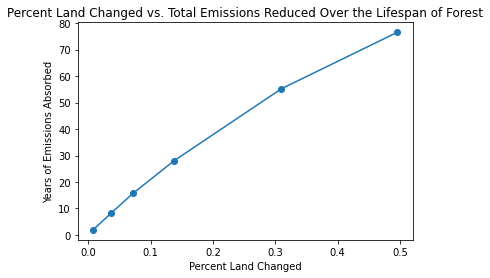

In [102]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [t / (-18.78e9 / conversion) for t in total_emissions], marker="o")
plt.title("Percent Land Changed vs. Total Emissions Reduced Over the Lifespan of Forest")
plt.xlabel("Percent Land Changed")
plt.ylabel("Years of Emissions Absorbed")
plt.show()